the mean of the target = 4600.663094339622
the median of the target = 4270.0


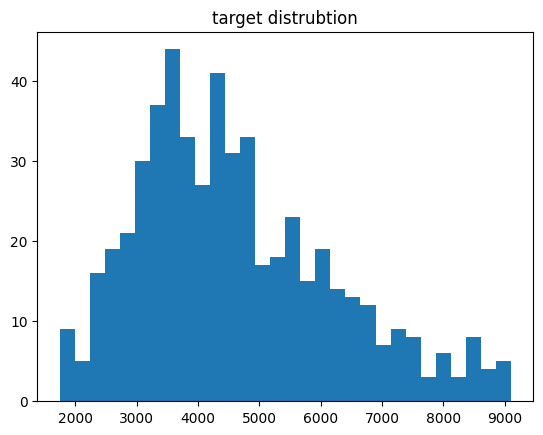

In [98]:
import pandas as pd 
import matplotlib.pyplot as plt 

data = pd.read_csv("cleaned_data.csv")
data = data.sample(frac=1 , random_state=42).reset_index(drop=True)



print(f"the mean of the target = {data['price'].mean()}")
print(f"the median of the target = {data['price'].median()}")



plt.hist(data['price'] , bins=30)
plt.title("target distrubtion")
plt.show()


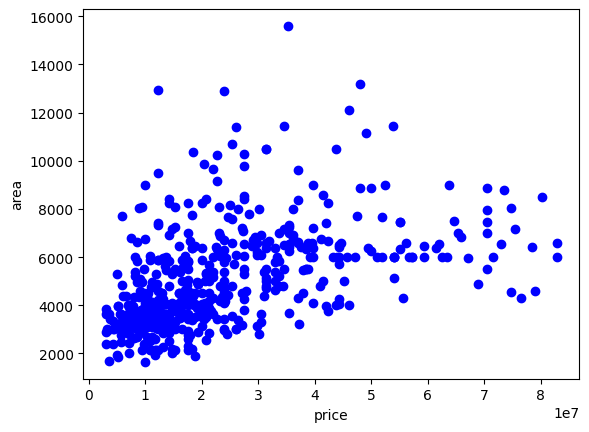

In [99]:
import numpy as np 
area = data['area']
target = data['price'] **2

plt.scatter(target , area , color= 'blue' )
plt.xlabel('price')
plt.ylabel('area')
plt.show()

In [100]:
data['stories'].sort_values(ascending=True).unique()

array([1, 2, 3, 4])

In [101]:
from preprocessing import corr_matrix 


corr_matrix = corr_matrix.drop(columns=['price'] ,index=['price'])
corr_list = []
for i in range(len(corr_matrix)):
    for j in range(i+1, len(corr_matrix)):  # j starts from i+1 to avoid duplicates and self-corr
        if corr_matrix.iloc[i, j] > 0.50:
            corr_list.append([corr_matrix.index[i], corr_matrix.columns[j] ,corr_matrix.iloc[i, j] ])


for cor in corr_list:
    print(cor)

['area', 'area_per_room', np.float64(0.5711170679002846)]
['bedrooms', 'total_rooms', np.float64(0.6112917337812375)]
['bathrooms', 'total_rooms', np.float64(0.5151976288738315)]
['stories', 'total_rooms', np.float64(0.9401624782090561)]


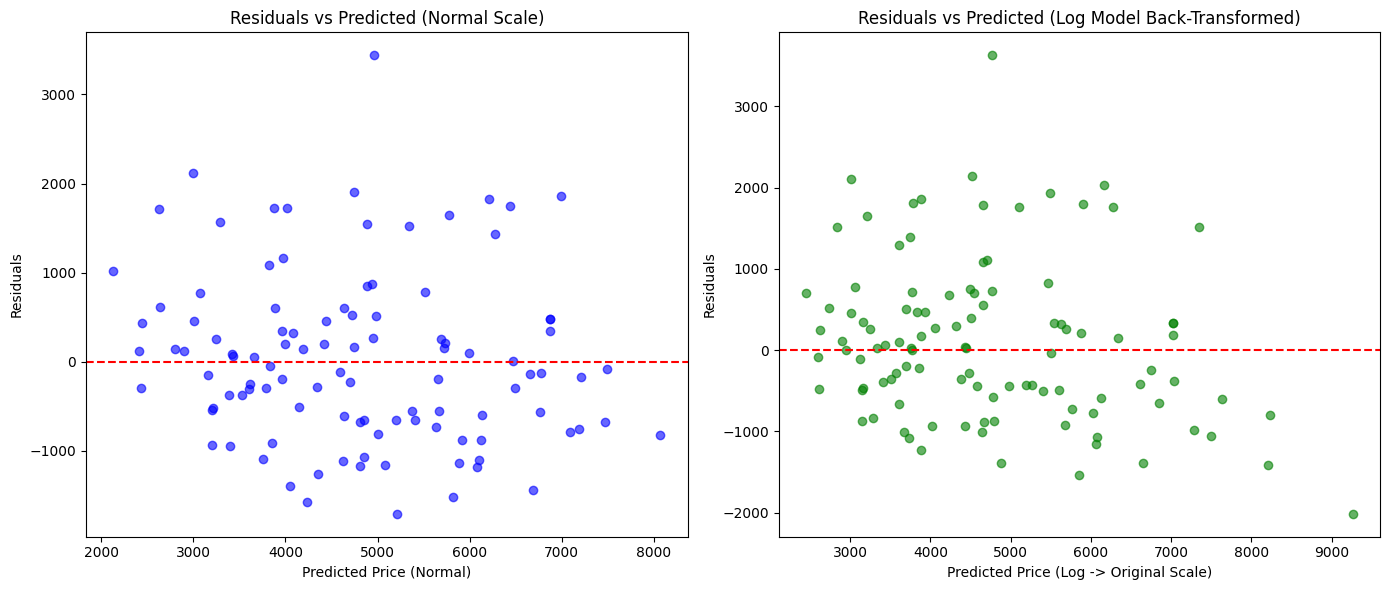

In [102]:
from testing import prediction_normal , prediction_log , y_test

import matplotlib.pyplot as plt
import numpy as np

# Assume these are your predictions from both models
# normal model:
y_pred_normal = prediction_normal   # your model.predict(x_test) without log

y_true = y_test          # actual prices

# log model (back-transformed):
y_pred_log = prediction_log        # np.exp(your_log_model.predict(x_test))

# Compute residuals
residuals_normal = y_true - y_pred_normal
residuals_log = y_true - y_pred_log

# Create figure
plt.figure(figsize=(14,6))

# Plot 1: normal scale residuals
plt.subplot(1,2,1)
plt.scatter(y_pred_normal, residuals_normal, alpha=0.6, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price (Normal)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Normal Scale)")

# Plot 2: log model residuals (back-transformed)
plt.subplot(1,2,2)
plt.scatter(y_pred_log, residuals_log, alpha=0.6, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price (Log -> Original Scale)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Log Model Back-Transformed)")

plt.tight_layout()
plt.show()

check up the high residual samples 

In [103]:
import numpy as np


data_load = np.load('test_data.npz', allow_pickle=True)
columns = data_load['columns']
x_test_raw = data_load['x_test']

# Convert to DataFrame FIRST so everything is aligned
x_test = pd.DataFrame(x_test_raw, columns=columns)
# Assuming y_test and prediction_normal are already in your environment
y_test_df = pd.DataFrame(y_test, columns=['price'])

# Calculate errors using the aligned data
# .values.flatten() ensures we are comparing 1D arrays
errors = np.abs(y_test_df['price'].values - prediction_normal.flatten())

# Get the positional index
pos_index = np.argmax(errors)

# Get the ACTUAL original index label (This is what you need to drop it later!)
original_label = y_test_df.index[pos_index]

outlier_row = x_test.iloc[[pos_index]] 
outlier_price = y_test_df.iloc[[pos_index]]

print(f"Position in Test Set: {pos_index}")
print(f"Original Index Label: {original_label}") # This tells you if it's '67'
print(f"Actual Price:\n{outlier_price}")
print(f"predicted price {prediction_normal[67]}")
print(f"residual is {outlier_price - prediction_normal[67]}")
print("--- House Details ---")
outlier_row

#a house that big with those "basic" specs is extremely rare. It’s likely either a warehouse converted into a living space, an old farmhouse, or a data entry error.

Position in Test Set: 67
Original Index Label: 67
Actual Price:
     price
67  8400.0
predicted price [4960.02916891]
residual is           price
67  3439.970831
--- House Details ---


,area,airconditioning,bathrooms,stories,area_squared,bedrooms,parking,mainroad,prefarea,guestroom,furnishingstatus_unfurnished
67,8875,0,1,1,78765625,3,1,1,0,0,0


In [104]:
# 1. Calculate residuals for the whole set
current_errors = np.abs(y_test.flatten() - prediction_normal.flatten())

# 2. Find all indices where the error is greater than, say, 2500
# (This catches the '8400' house and any other monsters)
bad_indices = np.where(current_errors > 2500)[0]

print(f"Removing {len(bad_indices)} massive outliers...")

# 3. Delete them all at once
x_test_final = np.delete(x_test, bad_indices, axis=0)
y_test_final = np.delete(y_test, bad_indices, axis=0)

Removing 1 massive outliers...
